In [3]:
import pygad
import numpy as np
import scipy.integrate as sp
import matplotlib.pyplot as plt
import json
from neuron import h
from neuron.units import ms, mV
from neuron_models import *
def userdir(f): return [ item for item in dir(f) if not item[:1] == "_"]

/home/kanisorn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [34]:
ga_instance = pygad.load(filename="FS_NoAdaptation")

In [39]:
ga_instance.best_solution()

(array([93.20655313,  1.78586121, 95.86512377]), 8.996411306003984e-06, 0)

In [40]:
apeak = HodgkinHuxleyModel()
apeak.amp = 95.2
apeak.area = 1.786
apeak.cm = 95.865
apeak.Initialize(-65)
apeak.ContinueRun(250)

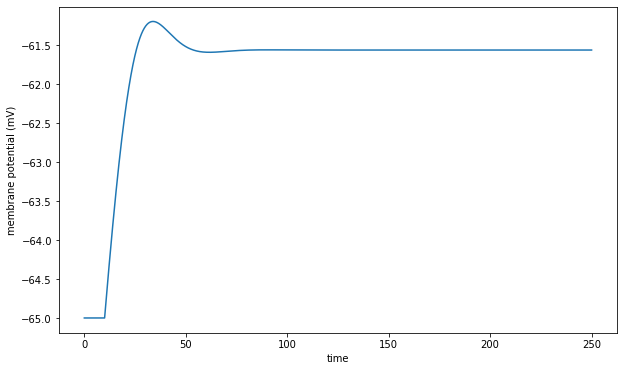

In [41]:
plt.rcParams['figure.figsize']=(10,6)
plt.xlabel('time')
plt.ylabel('membrane potential (mV)')
plt.plot(apeak.ts, apeak.ys[:,0])
#plt.plot(ts,ys_2{:,0})
plt.show()

In [7]:
soma = h.Section(name="soma")
soma.insert("hh")
soma.L = 20
soma.diam = 20

In [8]:
iclamp = h.IClamp(soma(0.5))
iclamp.amp = 0.1
iclamp.delay = 10
iclamp.dur = 200

In [9]:
v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [10]:
h.load_file("stdrun.hoc")
h.finitialize(-65*mV)
h.continuerun(250*ms)

0.0

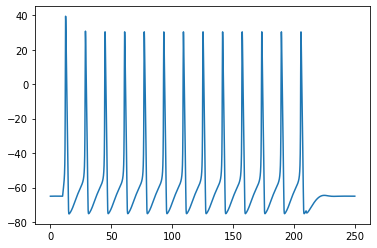

In [11]:
plt.plot(t,v)

In [12]:
class IzhikevichModel():
  def __init__(self, params):
    self.k = params["k"]
    self.a = params["a"]
    self.b = params["b"]
    self.d = params["d"]
    self.C = params["C"]
    self.Vr = params["Vr"]
    self.Vt = params["Vt"]
    self.Vp = params["Vp"]
    self.c = params["c"]
    self.dt = .025
    self.v = self.Vr
    self.u = 0
    self.t = 0
    self.vs = np.array([self.v])
    self.ts = np.array([self.t])

    self.amp = params['I']
    self.delay = 2
    self.dur = 40
    return None
  def I(self, t):
    return self.amp if (t > self.delay) and (t < self.dur + self.delay) else 0
  def Dv(self, v, u, i):
    return (1/self.C)*(self.k*(v-self.Vr)*(v-self.Vt) - u + i)
  def Du(self, v, u):
    return self.a*(self.b*(v-self.Vr) - u)
  def Initialize(self):
    self.v = self.Vr
    self.u = 0
    self.t = 0
    self.vs = np.array([self.v])
    self.ts = np.array([self.t])
    steady = False
    while (not steady):
      tmp_v = self.v
      tmp_u = self.u
      if (self.v >= self.Vp) :
        self.v = self.c
        self.u += self.d
      else:
        self.v += self.Dv(self.v, self.u, self.I(self.t))*self.dt
        self.u += self.Du(self.v, self.u)*self.dt
      if (np.abs(tmp_v - self.v) < 1e-5) and (np.abs(tmp_u - self.u) < 0.01):
        steady = True
    return None
  def ContinueRun(self, t_end):
    while (self.t < t_end):
      if (self.v >= self.Vp) :
        self.v = self.c
        self.u += self.d
      else:
        self.v += self.Dv(self.v, self.u, self.I(self.t))*self.dt
        self.u += self.Du(self.v, self.u)*self.dt
      self.t += self.dt
      self.vs = np.append(self.vs, self.v)
      self.ts = np.append(self.ts, self.t)
    return None

In [13]:
with open("./Izhikevich_Model_Params.json") as json_file:
    types_params = json.load(json_file)
neuron = IzhikevichModel(types_params['FS_NoAdaptation'])
neuron.v

-65

In [14]:
#neuron.amp = 500
neuron.dur = 200
neuron.delay = 10
neuron.Initialize()

In [15]:
neuron.ContinueRun(250)

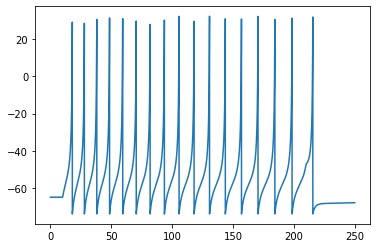

In [16]:
plt.plot(neuron.ts, neuron.vs)

In [17]:
len(neuron.vs)

10001

In [32]:
soma = h.Section(name="soma")
soma.insert("hh")
soma.L = 20
soma.diam = 20
iclamp = h.IClamp(soma(0.5))
iclamp.amp = 0.1
iclamp.delay = 10
iclamp.dur = 200
v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
h.load_file("stdrun.hoc")
h.finitialize(-65*mV)
h.continuerun(250*ms)

with open("./Izhikevich_Model_Params.json") as json_file:
    types_params = json.load(json_file)
neuron = IzhikevichModel(types_params['FS_NoAdaptation'])
neuron.dur = 200
neuron.delay = 10
neuron.Initialize()
neuron.ContinueRun(250)

solution = [iclamp.amp, soma.L, soma.diam, soma.cm]

def fitness_func(ga_instance, solution, solution_idx):
    iclamp.amp = abs(solution[0])
    soma.L = abs(solution[1])
    soma.diam = abs(solution[2])
    soma.cm = abs(solution[3])
    h.finitialize(-65*mV)
    h.continuerun(250*ms)
    vs_hh = np.array(v)
    fitness = 1.0/(0.001 + np.sum(np.abs(vs_hh - neuron.vs)))
    return fitness    
    
num_generations = 10
num_parents_mating = 80

fitness_function = fitness_func

sol_per_pop = 100
num_genes = len(solution)

init_range_low = 0
init_range_high = 100

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"

def on_gen(ga_instance):
    ga_instance.best_solution()

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_by_replacement=True,
                       mutation_type=mutation_type,
                       mutation_num_genes=2,
                       random_mutation_min_val=0,
                       random_mutation_max_val=100)

In [40]:
ga_instance.run()

In [73]:
print("|\tno. of generations\t|\tminimum fitness \t|")
print("-----------------------------------------------------------------")
print("|\t\t{}\t\t|\t{:.2E}\t\t|".format(ga_instance.generations_completed, ga_instance.last_generation_fitness.min()))

|	no. of generations	|	minimum fitness 	|
-----------------------------------------------------------------
|		15		|	6.18E-07		|


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


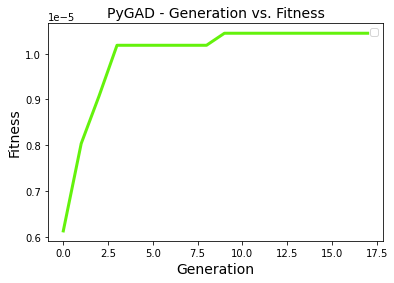

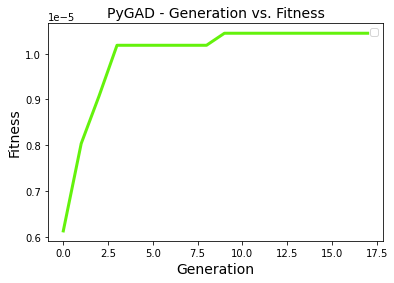

In [42]:
ga_instance.plot_fitness()

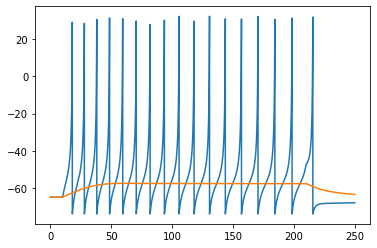

In [36]:
best_solution = ga_instance.best_solution()[0]
iclamp.amp = abs(best_solution[0])
soma.L = abs(best_solution[1])
soma.diam = abs(best_solution[2])
soma.cm = abs(best_solution[3])
h.finitialize(-65*mV)
h.continuerun(250*ms)
vs_hh = np.array(v)

plt.plot(neuron.ts, neuron.vs)
plt.plot(neuron.ts, vs_hh)

In [640]:
best_solution

array([ 2.03399558, 60.72635921, 62.37891444, 15.73696142])